# **Movie Analysis Notebook**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
movie = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('im.db.zip')

In [3]:
#specify the path to the zip file
zip_file_path = 'zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

#connect to extracted SQLite database
database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

## **Movie DF EDA**

In [4]:
# drop the 'Unnamed: 0' column from the movie dataframe
movie.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# convert release_date to datetime and filter for movies
movie['release_date'] = pd.to_datetime(movie['release_date'])

# create a new column called release month that takes the month from release_date
movie['release_month'] = movie['release_date'].dt.month

# create a column called release_year and take just the year from release_date
movie['release_year'] = pd.to_datetime(movie['release_date']).dt.year

# drop the release_date column
movie.drop('release_date', axis=1, inplace=True)

## **Movie_Budget EDA**

In [6]:
# convert release_date to datetime format
movie_budget['release_date'] = pd.to_datetime(movie_budget['release_date'])

# create new columns release_year and release_month
movie_budget['release_year'] = movie_budget['release_date'].dt.year
movie_budget['release_month'] = movie_budget['release_date'].dt.month

# drop release_date column from movie_budget dataframe
movie_budget.drop('release_date', axis=1, inplace=True)

# convert production_budget, domestic_gross, and worldwide_gross to numerical values
movie_budget['production_budget'] = pd.to_numeric(movie_budget['production_budget'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['domestic_gross'] = pd.to_numeric(movie_budget['domestic_gross'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['worldwide_gross'] = pd.to_numeric(movie_budget['worldwide_gross'].str.replace('$','').str.replace(',',''), errors='coerce')

# Merging Movie and Movie_Budget

In [7]:
# merge movie_budget and movie dataframes using 'movie' and 'title' columns respectively
merged_df = pd.merge(movie_budget, movie, left_on='movie', right_on='title')

In [8]:
merged_df.head()

,id_x,movie,production_budget,domestic_gross,worldwide_gross,release_year_x,release_month_x,genre_ids,id_y,original_language,original_title,popularity,title,vote_average,vote_count,release_month_y,release_year_y
0,1,Avatar,425000000,760507625,2776345279,2009,12,"[28, 12, 14, 878]",19995,en,Avatar,26.526,Avatar,7.4,18676,12,2009
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,Pirates of the Caribbean: On Stranger Tides,6.4,8571,5,2011
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,Avengers: Age of Ultron,7.3,13457,5,2015
3,7,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,Avengers: Infinity War,8.3,13948,4,2018
4,9,Justice League,300000000,229024295,655945209,2017,11,"[28, 12, 14, 878]",141052,en,Justice League,34.953,Justice League,6.2,7510,11,2017


In [9]:
merged_df.drop(['id_y', 'original_title', 'title', 'release_year_x', 'release_month_x'], axis=1, inplace=True)

In [10]:
merged_df.rename(columns={'id_x': 'id', 'release_year_y': 'release_year', 'release_month_y': 'release_month'}, inplace=True)

# Merging Merged_df to Movie_gross

In [11]:
# merge merged_df and movie_gross dataframes using 'movie' and 'title' columns respectively
movie_merge2_df = pd.merge(merged_df, movie_gross, left_on='movie', right_on='title')

In [12]:
movie_merge2_df.drop(['title'], axis=1, inplace=True)

In [13]:
movie_merge2_df

,id,movie,production_budget,domestic_gross_x,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,studio,domestic_gross_y,foreign_gross,year
0,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[12, 28, 14]",en,30.579,6.4,8571,5,2011,BV,241100000.0,804600000,2011
1,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"[28, 12, 878]",en,44.383,7.3,13457,5,2015,BV,459000000.0,946400000,2015
2,7,Avengers: Infinity War,300000000,678815482,2048134200,"[12, 28, 14]",en,80.773,8.3,13948,4,2018,BV,678800000.0,"1,369.5",2018
3,9,Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.953,6.2,7510,11,2017,WB,229000000.0,428900000,2017
4,9,Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.953,6.2,7510,11,2017,WB,229000000.0,428900000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,68,Sound of My Voice,135000,408015,429448,"[878, 18, 9648, 53]",en,7.212,6.4,169,1,2011,FoxS,408000.0,NaN,2012
1391,73,Your Sister's Sister,120000,1597486,3090593,"[18, 35]",en,7.115,6.6,192,6,2012,IFC,1600000.0,NaN,2012
1392,80,The Gallows,100000,22764410,41656474,"[27, 53]",en,9.166,4.8,591,7,2015,WB (NL),22800000.0,20200000,2015
1393,86,A Ghost Story,100000,1594798,2769782,"[18, 14, 10749]",en,11.886,7.0,906,7,2017,A24,1600000.0,NaN,2017


In [14]:
# convert foreign_gross and domestic_gross_y columns to float
movie_merge2_df['foreign_gross'] = movie_merge2_df['foreign_gross'].str.replace(',', '').astype(float)
movie_merge2_df['domestic_gross_y'] = movie_merge2_df['domestic_gross_y'].astype(float)

In [15]:
# replace 0 or missing values in foreign_gross column with the difference between worldwide_gross and domestic_gross_x
movie_merge2_df['foreign_gross'] = movie_merge2_df['foreign_gross'].replace(0, np.nan)
movie_merge2_df['foreign_gross'] = movie_merge2_df['foreign_gross'].fillna(movie_merge2_df['worldwide_gross'] - movie_merge2_df['domestic_gross_x'])

In [16]:
# create a new column called total_gross by adding domestic_gross_y to foreign_gross
movie_merge2_df['total_gross'] = movie_merge2_df['domestic_gross_y'] + movie_merge2_df['foreign_gross']

In [17]:
# create a column called profit by subtracting worldwide_gross from production budget
movie_merge2_df['total_profit'] = movie_merge2_df['total_gross'] - movie_merge2_df['production_budget']

# calculate profit margin by dividing profit by production budget
movie_merge2_df['profit_margin'] = movie_merge2_df['total_profit'] / movie_merge2_df['production_budget']

In [18]:
movie_merge2_df.drop(['domestic_gross_x', 'worldwide_gross','year'], axis=1, inplace=True)

In [19]:
movie_merge2_df = movie_merge2_df[['genre_ids', 'movie', 'original_language', 'release_month', 'release_year', 'studio', 'production_budget','domestic_gross_y', 'foreign_gross', 'total_gross', 'total_profit', 'profit_margin', 'popularity', 'vote_average', 'vote_count']]

# SQL: creating a director dataframe

In [20]:
# execute the SQL query and store the result in a dataframe
director_df = pd.read_sql("""
SELECT DISTINCT movie_basics.*, principals.person_id, persons.primary_name, persons.birth_year, persons.death_year, principals.category, movie_ratings.averagerating, movie_ratings.numvotes
FROM movie_basics
INNER JOIN principals
    USING(movie_id)
INNER JOIN persons
    USING(person_id)
INNER JOIN movie_ratings
    USING(movie_id)
WHERE principals.category = 'director' 
GROUP BY primary_title;
""", conn)

In [21]:
# rename the 'primary_name' column to 'director' in the director_df dataframe
director_df = director_df.rename(columns={'primary_name': 'director'})

# Merging Director_df to Movie_Merge2

In [22]:
movie_merged_director_df = pd.merge(movie_merge2_df, director_df, left_on='movie', right_on='primary_title')

In [23]:
movie_merged_director_df

,genre_ids,movie,original_language,release_month,release_year,studio,production_budget,domestic_gross_y,foreign_gross,total_gross,...,start_year,runtime_minutes,genres,person_id,director,birth_year,death_year,category,averagerating,numvotes
0,"[12, 28, 14]",Pirates of the Caribbean: On Stranger Tides,en,5,2011,BV,410600000,241100000.0,804600000.0,1.045700e+09,...,2011,136.0,"Action,Adventure,Fantasy",nm0551128,Rob Marshall,1960.0,NaN,director,6.6,447624
1,"[28, 12, 878]",Avengers: Age of Ultron,en,5,2015,BV,330600000,459000000.0,946400000.0,1.405400e+09,...,2015,141.0,"Action,Adventure,Sci-Fi",nm0923736,Joss Whedon,1964.0,NaN,director,7.3,665594
2,"[12, 28, 14]",Avengers: Infinity War,en,4,2018,BV,300000000,678800000.0,1369.5,6.788014e+08,...,2018,149.0,"Action,Adventure,Sci-Fi",nm0751577,Anthony Russo,1970.0,NaN,director,8.5,670926
3,"[28, 12, 14, 878]",Justice League,en,11,2017,WB,300000000,229000000.0,428900000.0,6.579000e+08,...,2017,120.0,"Action,Adventure,Fantasy",nm0811583,Zack Snyder,1966.0,NaN,director,6.5,329135
4,"[28, 12, 14, 878]",Justice League,en,11,2017,WB,300000000,229000000.0,428900000.0,6.579000e+08,...,2017,120.0,"Action,Adventure,Fantasy",nm0811583,Zack Snyder,1966.0,NaN,director,6.5,329135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,"[18, 878]",Another Earth,en,7,2011,FoxS,175000,1300000.0,456000.0,1.756000e+06,...,2011,92.0,"Drama,Romance,Sci-Fi",nm2648685,Mike Cahill,1979.0,NaN,director,7.0,85839
1334,"[878, 18, 9648, 53]",Sound of My Voice,en,1,2011,FoxS,135000,408000.0,21433.0,4.294330e+05,...,2011,85.0,"Drama,Mystery,Sci-Fi",nm2610231,Zal Batmanglij,NaN,NaN,director,6.6,19387
1335,"[18, 35]",Your Sister's Sister,en,6,2012,IFC,120000,1600000.0,1493107.0,3.093107e+06,...,2011,90.0,"Comedy,Drama",nm1119645,Lynn Shelton,NaN,NaN,director,6.7,24780
1336,"[27, 53]",The Gallows,en,7,2015,WB (NL),100000,22800000.0,20200000.0,4.300000e+07,...,2015,81.0,"Horror,Mystery,Thriller",nm4000389,Travis Cluff,NaN,NaN,director,4.2,17763


In [24]:
movie_merged_director_df.drop(['start_year','primary_title','person_id','category'], axis=1, inplace=True)

# Merging Movie info into the final df

In [25]:
movie_final= pd.merge(movie_merged_director_df, movie_info, on='director')

In [26]:
movie_final.head()

,genre_ids,movie,original_language,release_month,release_year,studio_x,production_budget,domestic_gross_y,foreign_gross,total_gross,...,synopsis,rating,genre,writer,theater_date,dvd_date,currency,box_office,runtime,studio_y
0,"[12, 28, 14]",Pirates of the Caribbean: On Stranger Tides,en,5,2011,BV,410600000,241100000.0,804600000.0,1.045700e+09,...,"In the years before World War II, a Japanese c...",PG-13,Drama|Romance,Robin Swicord,"Dec 16, 2005","Mar 28, 2006",$,"57,000,000",105 minutes,Sony Pictures
1,"[14, 10751, 35]",Mary Poppins Returns,en,12,2018,BV,130000000,172000000.0,177600000.0,3.496000e+08,...,"In the years before World War II, a Japanese c...",PG-13,Drama|Romance,Robin Swicord,"Dec 16, 2005","Mar 28, 2006",$,"57,000,000",105 minutes,Sony Pictures
2,"[28, 12, 878]",Avengers: Age of Ultron,en,5,2015,BV,330600000,459000000.0,946400000.0,1.405400e+09,...,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,"25,335,935",119 minutes,Universal Pictures
3,"[28, 12, 80]",Spectre,en,11,2015,Sony,300000000,200100000.0,680600000.0,8.807000e+08,...,"Titanic shipmates Kathy Bates, Leonardo DiCapr...",R,Drama,Justin Haythe,"Dec 15, 2008","Jun 2, 2009",$,"22,877,808",119 minutes,Paramount Vantage
4,"[28, 12, 80]",Spectre,en,11,2015,Sony,300000000,200100000.0,680600000.0,8.807000e+08,...,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Action and Adventure|Mystery and Suspense,John Logan|Robert Wade|Neal Purvis,"Nov 9, 2012","Mar 11, 2013",$,"299,300,000",145 minutes,MGM


In [27]:
movie_final.drop(['synopsis','runtime','dvd_date','theater_date','currency','id',], axis=1, inplace=True)

In [28]:
movie_final.drop(['genre'],axis=1,inplace=True)

In [29]:
movie_final.rename(columns={'domestic_gross_y': 'domestic_gross'}, inplace=True)

In [30]:
movie_final = movie_final[movie_final['total_gross'] >= 0]
movie_final = movie_final[movie_final['profit_margin'] >= 0]

In [31]:
movie_final.drop_duplicates(subset=['movie'], keep='first', inplace=True)

In [32]:
# Replace any value in the studio_x column that contains 'WB' with 'WB'
movie_final['studio_x'] = movie_final['studio_x'].apply(lambda x: 'WB' if 'WB' in str(x) else x)

# Replace any value in the studio_x column that contains 'fox' with 'Fox'
movie_final['studio_x'] = movie_final['studio_x'].apply(lambda x: 'Fox' if 'fox' in str(x).lower() else x)

In [34]:
movie_final.drop(['genre_ids','vote_count', 'vote_average', 'averagerating', 'numvotes', 'total_profit', 'writer', 'original_title', 'box_office'], axis=1, inplace=True)

In [35]:
# convert production budget column to numerical dtype
movie_final['production_budget'] = pd.to_numeric(movie_final['production_budget'], errors='coerce')

In [40]:
movie_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 650
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              254 non-null    object 
 1   original_language  254 non-null    object 
 2   release_month      254 non-null    int64  
 3   release_year       254 non-null    int64  
 4   studio_x           254 non-null    object 
 5   production_budget  254 non-null    int64  
 6   domestic_gross     254 non-null    float64
 7   foreign_gross      254 non-null    float64
 8   total_gross        254 non-null    float64
 9   profit_margin      254 non-null    float64
 10  popularity         254 non-null    float64
 11  movie_id           254 non-null    object 
 12  runtime_minutes    254 non-null    float64
 13  genres             254 non-null    object 
 14  director           254 non-null    object 
 15  birth_year         229 non-null    float64
 16  death_year         4 non-n

In [37]:
# Create a boolean mask for movies with total_gross over the high budget threshold
high_budget = 85000000
mid_budget = low_budget = 30000000

high_budget_mask = movie_final['total_gross'] > high_budget
low_budget_mask = movie_final['total_gross'] < low_budget
budget_mask = (movie_final['total_gross'] >= low_budget) & (movie_final['total_gross'] <= high_budget)

# Create a new dataframe for high budget movies
high_budget = movie_final[high_budget_mask]
low_budget = movie_final[low_budget_mask]
mid_budget = movie_final[budget_mask]

# **Visuals**

<AxesSubplot:>

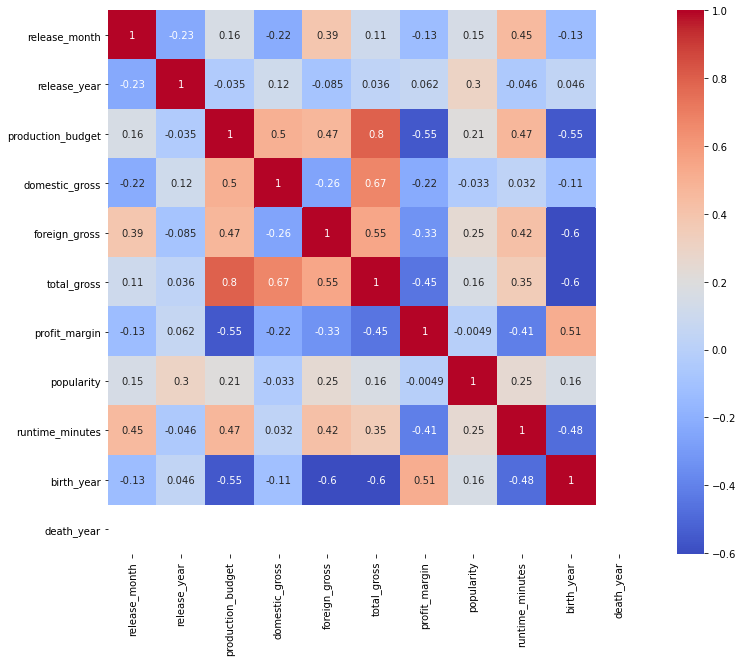

In [38]:
plt.figure(figsize=(12, 10))
corr = low_budget.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

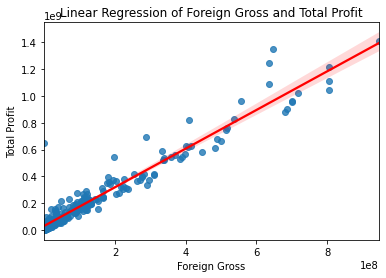

In [42]:
# create a linear regression model
model = LinearRegression()
X = movie_final[['foreign_gross']]
y = movie_final[['total_gross']]
model.fit(X, y)
# plot the regression line
sns.regplot(x=X, y=y, data=movie_final, line_kws={'color': 'red'})
plt.title('Linear Regression of Foreign Gross and Total Profit')
plt.xlabel('Foreign Gross')
plt.ylabel('Total Profit')
plt.show()

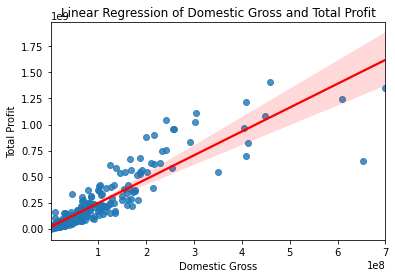

In [43]:
# create a linear regression model
model = LinearRegression()
X = movie_final[['domestic_gross']]
y = movie_final[['total_gross']]
model.fit(X, y)
# plot the regression line
sns.regplot(x=X, y=y, data=movie_final, line_kws={'color': 'red'})
plt.title('Linear Regression of Domestic Gross and Total Profit')
plt.xlabel('Domestic Gross')
plt.ylabel('Total Profit')
plt.show()

# Conclusion/Findings